In [1]:
import pandas as pd

DATA = '/kaggle/input/college-football-team-stats-2002-to-january-2024/cfb_box-scores_2002-2023.csv'
df = pd.read_csv(filepath_or_buffer=DATA)
df.head()

,season,week,date,time_et,game_type,away,home,rank_away,rank_home,conf_away,...,int_away,int_home,pen_num_away,pen_yards_away,pen_num_home,pen_yards_home,possession_away,possession_home,attendance,tv
0,2002,1.0,2002-08-22,7:30 PM,regular,Colorado State,Virginia,NaN,NaN,mwc,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,57120.0,NaN
1,2002,1.0,2002-08-23,8:00 PM,regular,Fresno State,Wisconsin,NaN,25.0,wac,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,75136.0,NaN
2,2002,1.0,2002-08-24,2:30 PM,regular,Texas Tech,Ohio State,NaN,13.0,big12,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100037.0,NaN
3,2002,1.0,2002-08-24,4:30 PM,regular,New Mexico,NC State,NaN,NaN,mwc,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,47018.0,NaN
4,2002,1.0,2002-08-24,7:45 PM,regular,Arizona State,Nebraska,NaN,10.0,pac12,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,77779.0,NaN


How big is our dataset?

<Axes: xlabel='season'>

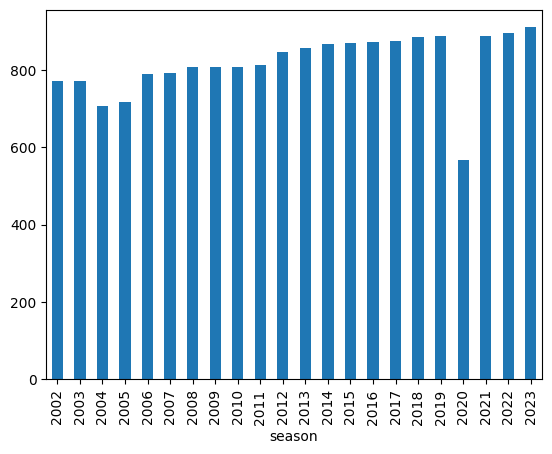

In [2]:
df['season'].value_counts().sort_index().plot(kind='bar')

We have roughly 800 games a year for 21 years; that's a lot of games.

Let's get just the win/loss figures first, and put them in a separate DataFrame.

In [3]:
win_loss_df = df[['season', 'home', 'away', 'score_away', 'score_home']].copy()
win_loss_df['winner'] = win_loss_df.apply(axis='columns', func=lambda x: 'home' if x['score_home'] > x['score_away'] else 'away')
win_loss_df['W'] = win_loss_df.apply(axis='columns', func=lambda x: x['home'] if x['score_home'] > x['score_away'] else x['away'])
win_loss_df['L'] = win_loss_df.apply(axis='columns', func=lambda x: x['home'] if x['score_home'] < x['score_away'] else x['away'])

Which teams have the most losses over the period of interest?

In [4]:
win_loss_df['L'].value_counts().head(n=10).to_frame().T

L,UNLV,New Mexico State,Kansas,Akron,Eastern Michigan,UTEP,Vanderbilt,UL-Monroe,New Mexico,Illinois
count,182,182,177,176,176,174,174,170,170,168


Which teams have the most wins over the period of interest?

In [5]:
win_loss_df['W'].value_counts().head(n=10).to_frame().T

W,Ohio State,Alabama,Georgia,Oklahoma,Boise State,Clemson,LSU,USC,Oregon,Wisconsin
count,244,243,232,231,231,220,216,205,203,202


In [6]:
win_loss_df['L score'] = win_loss_df[['score_away', 'score_home']].min(axis='columns')
win_loss_df['W score'] = win_loss_df[['score_away', 'score_home']].max(axis='columns')

In [7]:
win_loss_df.head(n=5)

,season,home,away,score_away,score_home,winner,W,L,L score,W score
0,2002,Virginia,Colorado State,35,29,away,Colorado State,Virginia,29,35
1,2002,Wisconsin,Fresno State,21,23,home,Wisconsin,Fresno State,21,23
2,2002,Ohio State,Texas Tech,21,45,home,Ohio State,Texas Tech,21,45
3,2002,NC State,New Mexico,14,34,home,NC State,New Mexico,14,34
4,2002,Nebraska,Arizona State,10,48,home,Nebraska,Arizona State,10,48


Let's collect each year into its own DataFrame.

In [8]:
wl = {season: win_loss_df[win_loss_df['season'] == season] for season in win_loss_df['season'].unique().tolist()}

In [9]:
print(list(wl.keys()))

[2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023]


How many distinct home teams do we have?

In [10]:
df['home'].nunique()

139

In [11]:
wl[2002][wl[2002]['home'] == 'Colorado State']

,season,home,away,score_away,score_home,winner,W,L,L score,W score
185,2002,Colorado State,Louisville,33,36,home,Colorado State,Louisville,33,36
369,2002,Colorado State,Wyoming,36,44,home,Colorado State,Wyoming,36,44
452,2002,Colorado State,BYU,10,37,home,Colorado State,BYU,10,37
702,2002,Colorado State,New Mexico,14,22,home,Colorado State,New Mexico,14,22
723,2002,Colorado State,UNLV,36,33,away,UNLV,Colorado State,33,36
760,2002,Colorado State,TCU,17,3,away,TCU,Colorado State,3,17


In [12]:
wl[2002][wl[2002]['away'] == 'Colorado State']

,season,home,away,score_away,score_home,winner,W,L,L score,W score
0,2002,Virginia,Colorado State,35,29,away,Colorado State,Virginia,29,35
27,2002,Colorado,Colorado State,19,14,away,Colorado State,Colorado,14,19
131,2002,UCLA,Colorado State,19,30,home,UCLA,Colorado State,19,30
269,2002,Nevada,Colorado State,32,28,away,Colorado State,Nevada,28,32
296,2002,Fresno State,Colorado State,30,32,home,Fresno State,Colorado State,30,32
423,2002,Utah,Colorado State,28,20,away,Colorado State,Utah,20,28
505,2002,Air Force,Colorado State,31,12,away,Colorado State,Air Force,12,31
657,2002,San Diego State,Colorado State,49,21,away,Colorado State,San Diego State,21,49


In [13]:
win_loss_df[win_loss_df['W'] == 'TCU'].groupby(by='season').size().to_frame().T

season,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,...,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
0,10,11,5,11,11,8,11,12,13,11,...,12,11,6,11,7,5,6,5,13,5


In [14]:
result = []
teams = df['home'].unique().tolist()
for team in teams:
    for season in range(2002, 2023):
        wins = 0
        games = 0
        points_scored = 0
        points_allowed = 0
        home_df = wl[season][wl[season]['home'] == team]
        wins += len(home_df[home_df['winner'] == 'home'])
        games += len(home_df)
        points_scored += home_df['score_home'].sum()
        points_allowed += home_df['score_away'].sum()
        away_df = wl[season][wl[season]['away'] == team]
        wins += len(away_df[away_df['winner'] == 'away'])
        games += len(away_df)
        losses = games - wins
        points_scored += away_df['score_away'].sum()
        points_allowed += away_df['score_home'].sum()
        result.append(pd.Series(data={'season': season, 'team': team, 'games': games, 'wins': wins, 'losses': losses, 
                                      'points scored': points_scored, 'points allowed': points_allowed} ))
result_df = pd.DataFrame(data=result)
result_df.head()

,season,team,games,wins,losses,points scored,points allowed
0,2002,Virginia,14,9,5,402,348
1,2003,Virginia,13,8,5,364,265
2,2004,Virginia,12,8,4,363,212
3,2005,Virginia,12,7,5,320,279
4,2006,Virginia,12,5,7,181,214


Now let's add our Pythagorean expectation and actual winning percentage.

In [15]:
from math import pow

result_df['actual'] = result_df['wins']/result_df['games']
result_df['numerator'] = result_df['points allowed'].apply(func=lambda x: pow(x, 2.37))
result_df['denominator'] = result_df['points scored'].apply(func=lambda x: pow(x, 2.37))
result_df['expected'] = result_df['numerator']/(result_df['numerator'] + result_df['denominator'])
result_df.head()

,season,team,games,wins,losses,points scored,points allowed,actual,numerator,denominator,expected
0,2002,Virginia,14,9,5,402,348,0.642857,1.055706e+06,1.485990e+06,0.415355
1,2003,Virginia,13,8,5,364,265,0.615385,5.534683e+05,1.174384e+06,0.320321
2,2004,Virginia,12,8,4,363,212,0.666667,3.261490e+05,1.166752e+06,0.218467
3,2005,Virginia,12,7,5,320,279,0.583333,6.252907e+05,8.653772e+05,0.419470
4,2006,Virginia,12,5,7,181,214,0.416667,3.334883e+05,2.242323e+05,0.597949


<Axes: xlabel='actual', ylabel='expected'>

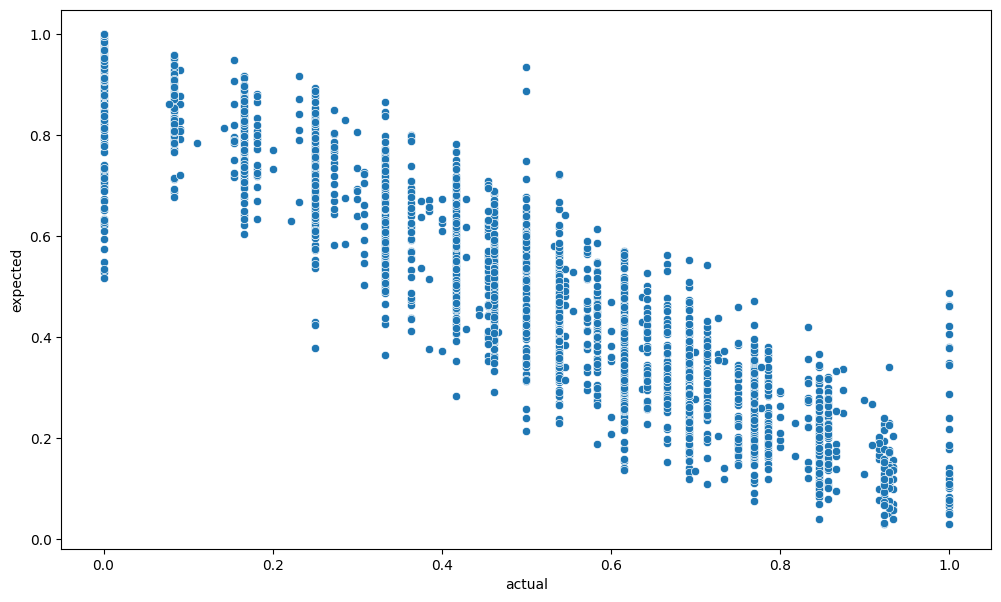

In [16]:
import matplotlib.pyplot as plt
from seaborn import scatterplot

FIGSIZE = (12, 7)
plt.figure(figsize=FIGSIZE)
scatterplot(data=result_df, x='actual', y='expected')